# Grid-Free Monte Carlo method for PDEs

In [6]:
%load_ext autoreload
%autoreload 2

In [188]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.optimize import minimize_scalar
from Random_walk import *
from geometry import *
from utils import *
from exemple import *
from scipy.spatial import Delaunay
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from scipy.interpolate import griddata 
import time

## Random Walk :

The first objective is to simulate a Random walk by implementing the Walk on Sphere algorithm. 

### Brownian Motion 

/var/folders/vm/951zcnvn12z0rcgdyj5svs0c0000gn/T/ipykernel_57956/1511044449.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((0, 0), R_2D, color='lightgray', fill=True, alpha=0.3, edgecolor='black', linewidth=1)
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Finish in 6292 step


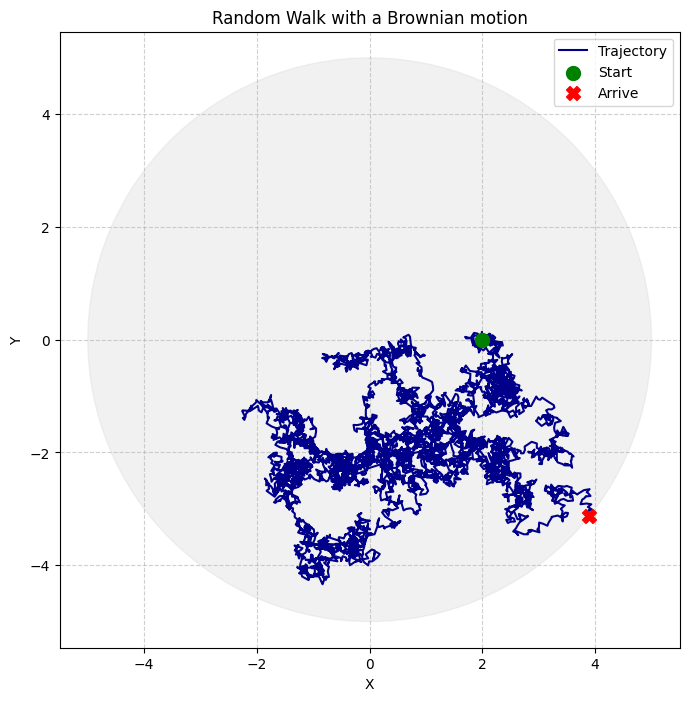

In [ ]:
R_2D = 5.0
n_dim_2D = 2
start_2D = np.array([2.0, 0.0])
step_2D = 0.05

trajectory_2D = random_walk_absorption_nD(n_dim_2D, R_2D, start_2D, step_2D) ## Brownian Motion

plt.figure(figsize=(8, 8))

# Ball
circle = plt.Circle((0, 0), R_2D, color='lightgray', fill=True, alpha=0.3, edgecolor='black', linewidth=1)
plt.gca().add_artist(circle)

# Trajectory
plt.plot(trajectory_2D[:, 0], trajectory_2D[:, 1], 
         color='darkblue', linewidth=1.5, label='Trajectory')

# Start/Finish
plt.scatter(trajectory_2D[0, 0], trajectory_2D[0, 1], color='green', s=100, label='Start', zorder=5, marker='o')
plt.scatter(trajectory_2D[-1, 0], trajectory_2D[-1, 1], color='red', s=100, label='Arrive', zorder=5, marker='X')


plt.title(f'Random Walk with a Brownian motion')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal') 
plt.xlim([-R_2D * 1.1, R_2D * 1.1])
plt.ylim([-R_2D * 1.1, R_2D * 1.1])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Walk on Sphere Algorithm 

Number of step 7
Final Point [-1.30604146  4.82341083]


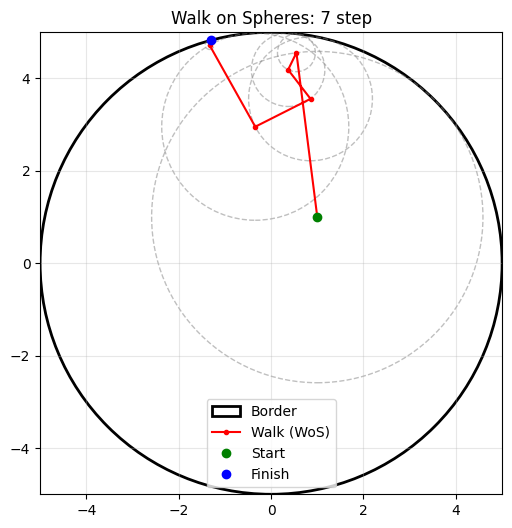

In [ ]:
point_depart = np.array([1.0, 1.0])
path = get_wos_path(point_depart, circle_sdf, epsilon=0.01) ## Walk on sphere path

print(f"Number of step {len(path) - 1}")
print(f"Final Point {path[-1]}")


# Visualisation 
fig, ax = plt.subplots(figsize=(6, 6))

boundary = plt.Circle((0, 0), R_2D, color='black', fill=False, linewidth=2, label='Border')
ax.add_patch(boundary)


for i in range(len(path) - 1):

    p_curr = path[i]
    r = circle_sdf(p_curr)
    
    # jump
    circle = plt.Circle((p_curr[0], p_curr[1]), r, color='gray', fill=False, linestyle='--', alpha=0.5)
    ax.add_patch(circle)

ax.plot(path[:, 0], path[:, 1], 'r.-', label='Walk (WoS)')
ax.plot(path[0, 0], path[0, 1], 'go', label='Start')
ax.plot(path[-1, 0], path[-1, 1], 'bo', label='Finish')

ax.set_aspect('equal')
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
plt.legend()
plt.title(f"Walk on Spheres: {len(path)-1} step")
plt.grid(True, alpha=0.3)
plt.show()

This first experiment shows us the efficiency of the Walk On Sphere walk comparing to a Brownian Motion. The Walk is globally faster than a classic brownian Motion (for touching the border).

- More complex geometry

/var/folders/vm/951zcnvn12z0rcgdyj5svs0c0000gn/T/ipykernel_57956/4262574783.py:18: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z, levels=[0], colors='black', linewidths=2, label='Bord')


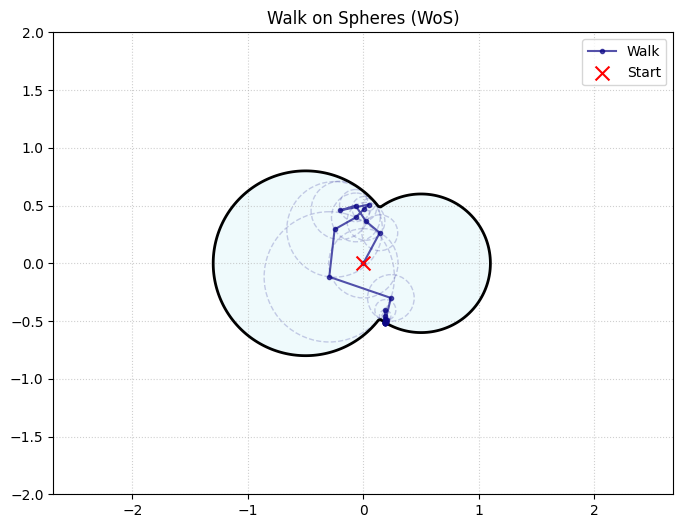

In [149]:
start_point = np.array([0.0, 0.0]) 

paths = []
paths.append(get_wos_path(start_point, sdf_peanut))


plt.figure(figsize=(8, 6))

x = np.linspace(-2, 2, 200)
y = np.linspace(-2, 2, 200)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = sdf_peanut(np.array([X[i, j], Y[i, j]]))

plt.contour(X, Y, Z, levels=[0], colors='black', linewidths=2, label='Bord')
plt.contourf(X, Y, Z, levels=[-10, 0], colors=['#e0f7fa'], alpha=0.5) 


colors = plt.cm.plasma(np.linspace(0, 1, len(paths)))

for i, path in enumerate(paths):
    
    plt.plot(path[:, 0], path[:, 1], '.-', color=colors[i], alpha=0.7, label=f'Walk')
    
    for point in path[:-1]: 
        radius = sdf_peanut(point)
        circle = plt.Circle(point, radius, color=colors[i], fill=False, linestyle='--', alpha=0.2)
        plt.gca().add_patch(circle)


plt.scatter(start_point[0], start_point[1], color='red', s=100, zorder=10, marker='x', label='Start')

plt.axis('equal')
plt.title("Walk on Spheres (WoS)")
plt.legend(loc='upper right')
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

## Laplace's equation

We wanna solve the following equation inside a domain $\Omega$ :

$$
\begin{cases}
\Delta u(x) = 0 & \text{for } x \in \Omega \\
u(x) = g(x) & \text{for } x \in \partial \Omega
\end{cases}
$$

where :
* $u(x)$ is the researched solution.
* $\partial \Omega$ is the border of the domain.
* $g(x)$ is the limit conditon.

We use the Kakutani's principle associated with the **mean property**. We obtain the following solution to our problem.

$$u(x) = \mathbb{E}[g(X_{\tau})]$$

where $X_{\tau}$ is the position of the walker when he touches the border $\partial \Omega$.



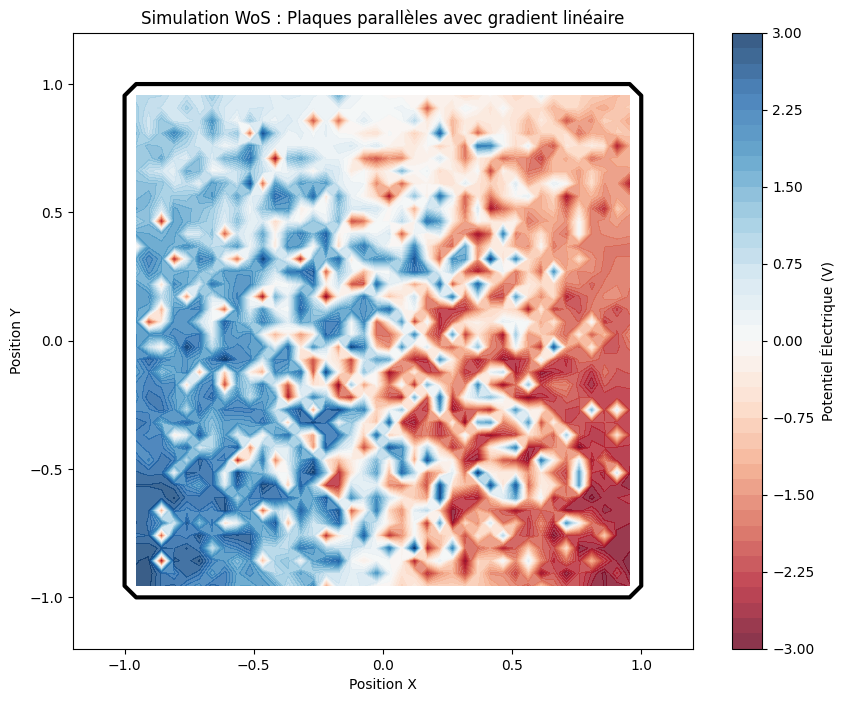

In [ ]:
res = 50 # Résolution de la grille
x = np.linspace(-1.2, 1.2, res)
y = np.linspace(-1.2, 1.2, res)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

for i in range(res):
    for j in range(res):
        p = np.array([X[i, j], Y[i, j]])
        if sdf_box(p) < 0:
            Z[i, j] = wos_poisson_2d(p,sdf_box,boundary_condition_plates)
        else:
            Z[i, j] = np.nan


plt.figure(figsize=(10, 8))
plt.contourf(X, Y, Z, levels=50, cmap='RdBu', alpha=0.8)
plt.colorbar(label='Potentiel Électrique (V)')

contour_mask = np.zeros_like(Z)
for i in range(res):
    for j in range(res):
        contour_mask[i,j] = sdf_box(np.array([X[i,j], Y[i,j]]))

plt.contour(X, Y, contour_mask, levels=[0], colors='black', linewidths=3)
plt.title("Simulation WoS : Plaques parallèles avec gradient linéaire")
plt.xlabel("Position X")
plt.ylabel("Position Y")
plt.show()

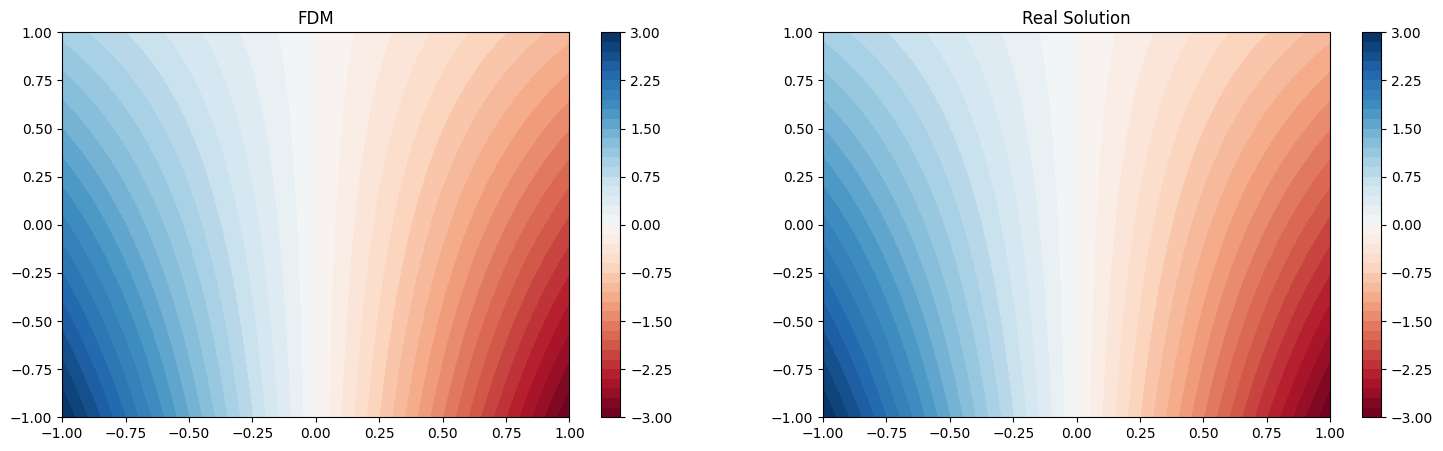

In [12]:
N = 60  # grid
max_iter = 5000  # number of iteration
x = np.linspace(-1, 1, N)
y = np.linspace(-1, 1, N)
X, Y = np.meshgrid(x, y)

V = np.zeros((N, N))

V[:, 0]  = -1 * (y - 2)
V[:, -1] =  1 * (y - 2)
V[0, :]  =  x * (-1 - 2)
V[-1, :] =  x * (1 - 2)

for k in range(max_iter):
    V[1:-1, 1:-1] = 0.25 * (
        V[1:-1, 0:-2] +  
        V[1:-1, 2:]   +  
        V[0:-2, 1:-1] +  
        V[2:, 1:-1]      
    )

V_exact = X * (Y - 2)
Error = np.abs(V - V_exact)

fig, ax = plt.subplots(1, 2, figsize=(18, 5))

im1 = ax[0].contourf(X, Y, V, levels=50, cmap='RdBu')
ax[0].set_title("FDM")
fig.colorbar(im1, ax=ax[0])

im2 = ax[1].contourf(X, Y, V_exact, levels=50, cmap='RdBu')
ax[1].set_title("Real Solution")
fig.colorbar(im2, ax=ax[1])


plt.show()

We find a good estimation of the real function. The time processing shows us that it is not always the best solution. 

## Poisson's equation 

We now include a source term by solving this equation :

$$
\begin{cases}
\Delta u(x) = -f(x) & \text{for } x \in \Omega \\
u(x) = g(x) & \text{for } x \in \partial \Omega
\end{cases}
$$

where :
* $f(x)$ is the source term.

The walk on sphere algorithm is still working but we must add a penalty corresponding to this new term:

$$u(x) = \mathbb{E} \left[ g(W_{\tau}) + \int_{0}^{\tau} \frac{1}{2} f(W_t) \, dt \right]$$

* $g(W_{\tau})$ is the border term (like Laplace).
* The second term corresponds to the source term until the exit time ($\tau$).



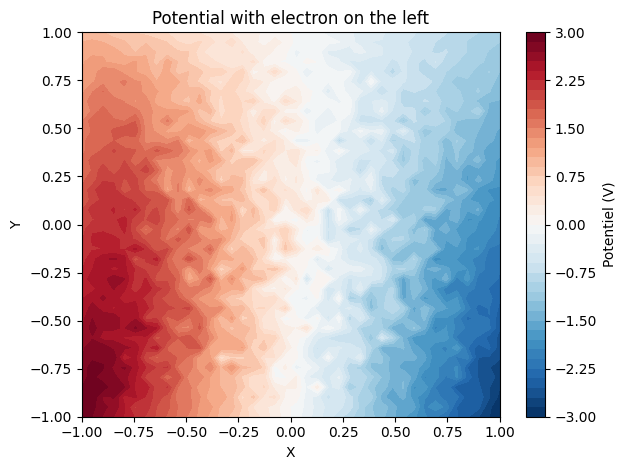

In [151]:
# grid
res = 40
x = np.linspace(-1.0, 1.0, res)
y = np.linspace(-1.0, 1.0, res)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

for i in range(res):
    for j in range(res):
        p = np.array([X[i, j], Y[i, j]])
        Z[i, j] = wos_poisson_2d(p, sdf_box, boundary_condition_plates, electron_density_term, n_walks=50)


# Heatmap
plt.contourf(X, Y, Z, levels=40, cmap='RdBu_r') # Rouge = Positif
plt.colorbar(label='Potentiel (V)')
plt.title("Potential with electron on the left")
plt.xlabel("X")
plt.ylabel("Y")


plt.tight_layout()
plt.show()

## Control Variates 

We have now to reduce the variance of our estimators. The first solution is to make a control variate of our solution. 

The core idea is to estimate an integral $\int \phi(x)$ using a function $\tilde{\phi}(x)$ whose integral $c = \int \tilde{\phi}(x)$ is known exactly. The variance-reduced estimator is defined as:

$$
F_{N} = c + \frac{1}{N} \sum_{i=1}^{N} (\phi(X_i) - \tilde{\phi}(X_i))
$$

The difference $\phi - \tilde{\phi}$ becomes "flat" (low variance), significantly reducing the error.


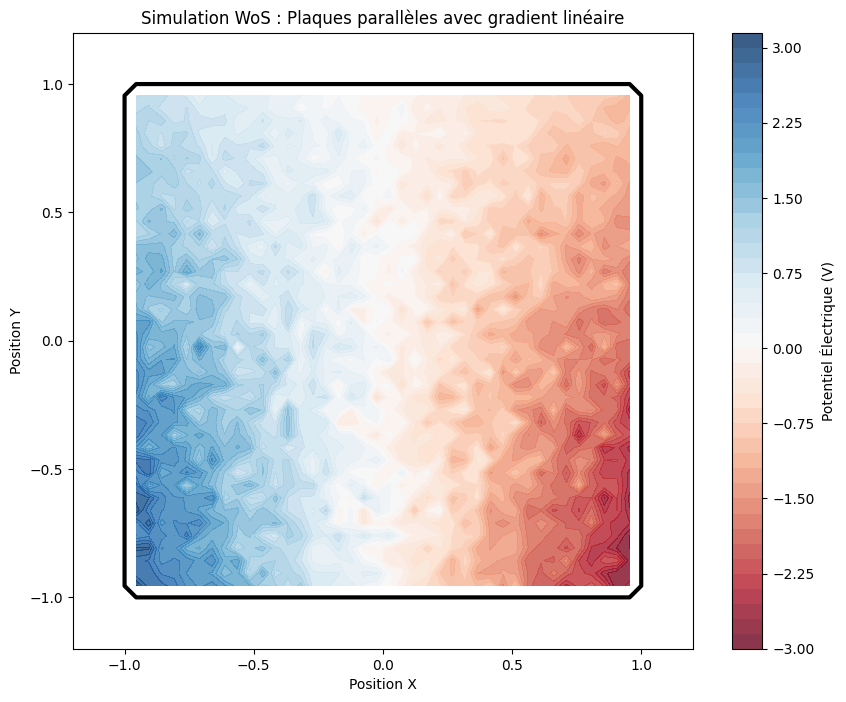

In [152]:
res = 50 
x = np.linspace(-1.2, 1.2, res) 
y = np.linspace(-1.2, 1.2, res)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

for i in range(res):
    for j in range(res):
        p = np.array([X[i, j], Y[i, j]])
        if sdf_box(p) < 0:
            Z[i, j] = wos_cv_2d(p,sdf_box,boundary_condition_plates, src=None)
        else:
            Z[i, j] = np.nan


plt.figure(figsize=(10, 8))
plt.contourf(X, Y, Z, levels=50, cmap='RdBu', alpha=0.8)
plt.colorbar(label='Potentiel Électrique (V)')

contour_mask = np.zeros_like(Z)
for i in range(res):
    for j in range(res):
        contour_mask[i,j] = sdf_box(np.array([X[i,j], Y[i,j]]))
plt.contour(X, Y, contour_mask, levels=[0], colors='black', linewidths=3)

plt.title("Simulation WoS : Plaques parallèles avec gradient linéaire")
plt.xlabel("Position X")
plt.ylabel("Position Y")
plt.show()

As we can see, the solution is more clean and has less noise than before making a reduction of variance for our estimators. 

## Polygon soup

A major advantage of WoS is in solving Polygon soup

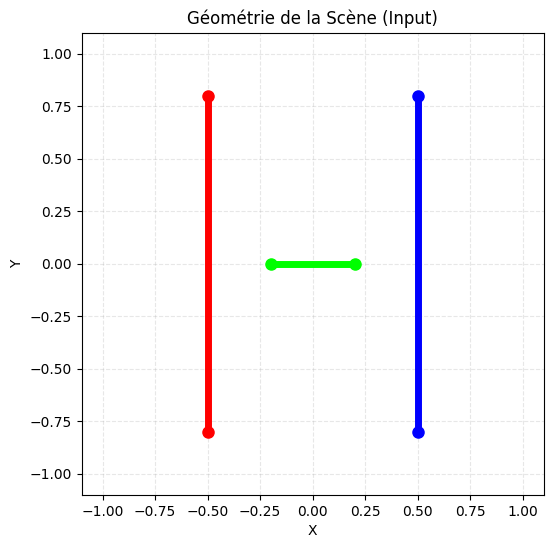

In [153]:
lines = [
    # Red Line
    {'a': np.array([-0.5, -0.8]), 'b': np.array([-0.5, 0.8]), 'color': np.array([1.0, 0.0, 0.0])},
    
    # Blue
    {'a': np.array([0.5, -0.8]),  'b': np.array([0.5, 0.8]),  'color': np.array([0.0, 0.0, 1.0])},
    
    # Green
    {'a': np.array([-0.2, 0.0]),  'b': np.array([0.2, 0.0]),  'color': np.array([0.0, 1.0, 0.0])}
]

A_vec = np.array([l['a'] for l in lines])
B_vec = np.array([l['b'] for l in lines])
Colors_vec = np.array([l['color'] for l in lines])

plt.figure(figsize=(6, 6))
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

for line in lines:
    x_coords = [line['a'][0], line['b'][0]]
    y_coords = [line['a'][1], line['b'][1]]
    
    plt.plot(x_coords, y_coords, color=line['color'], linewidth=5, marker='o', markersize=8)

plt.title("Géométrie de la Scène (Input)")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True, linestyle='--', alpha=0.3)
plt.gca().set_aspect('equal') 
plt.show()

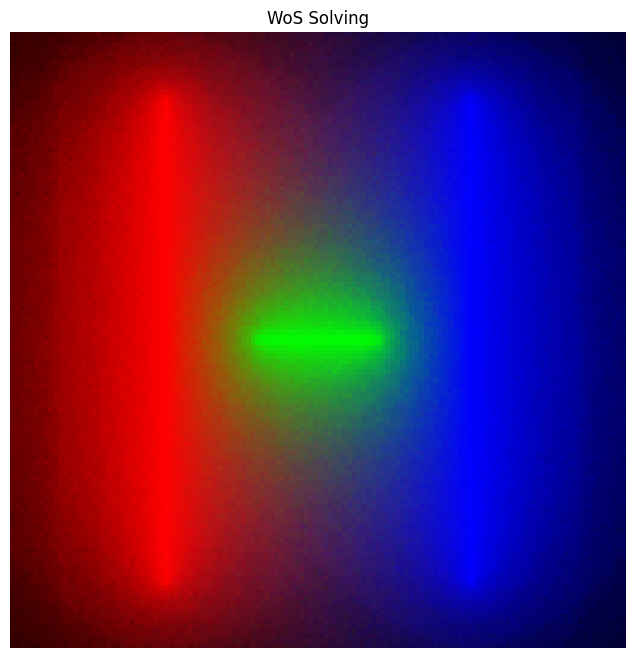

In [154]:
my_sdf = lambda p: get_min_dist_vectorized(p, A_vec, B_vec)
my_shader = lambda p: get_hit_color_vectorized(p, A_vec, B_vec, Colors_vec)

image = solve_wos_generic(
    res=128, 
    n_samples=1024, 
    sdf_func=my_sdf,       
    bc_func=my_shader,     
    bg_val=np.array([0., 0., 0.])
)

plt.figure(figsize=(8, 8))

plt.imshow(image, extent=[-1, 1, -1, 1], origin='upper')

plt.title("WoS Solving")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('off')
plt.show()


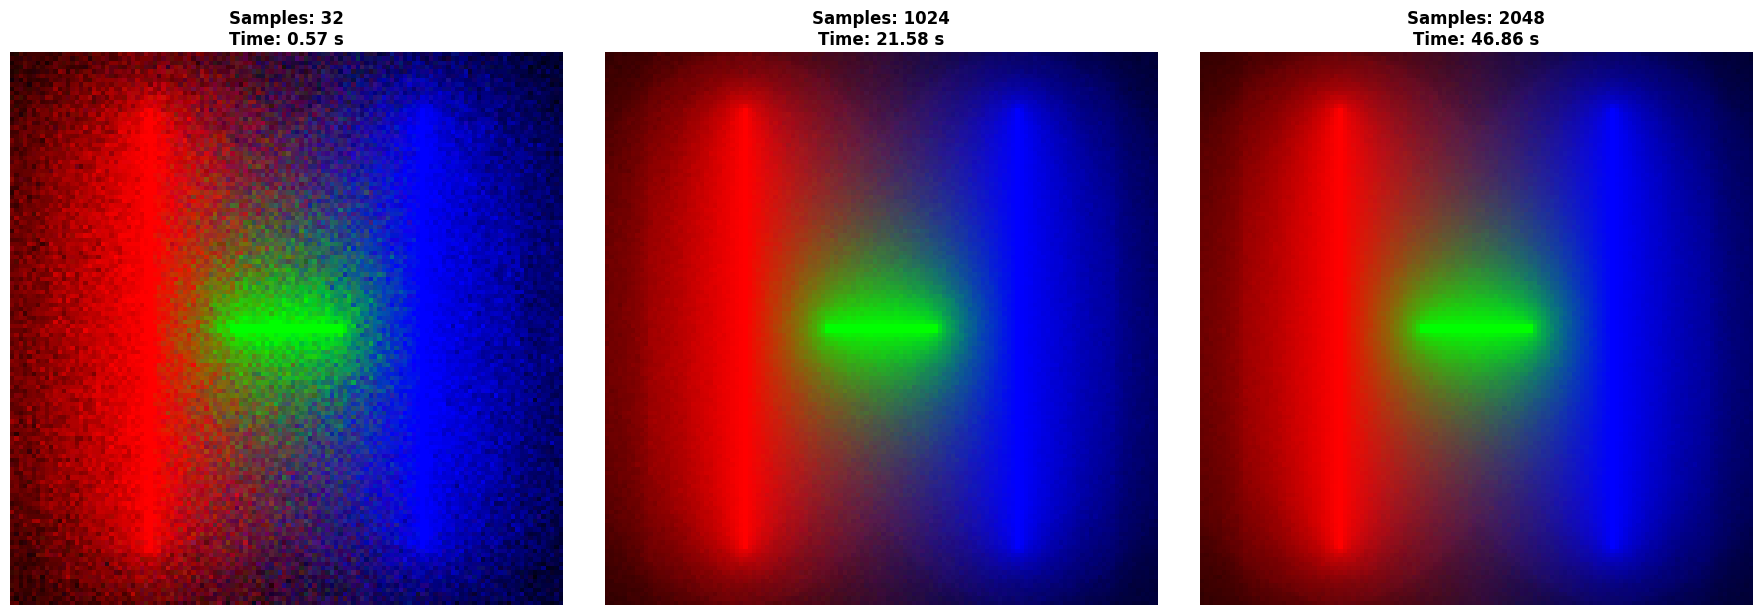

In [155]:
sample_counts = [32, 1024, 2048]
res = 128

plt.figure(figsize=(18, 6)) 

for i, n in enumerate(sample_counts):
    
    start_time = time.time()
    
    # Solver
    img = solve_wos_generic(
        res=res, 
        n_samples=n, 
        sdf_func=my_sdf,       
        bc_func=my_shader,     
        bg_val=np.array([0., 0., 0.]), 
        epsilon=1e-2
    )
    
    # computation time
    end_time = time.time()
    elapsed = end_time - start_time
    
    plt.subplot(1, 3, i + 1)
    plt.imshow(img, extent=[-1, 1, -1, 1], origin='upper')
    plt.title(f"Samples: {n}\nTime: {elapsed:.2f} s", fontsize=12, fontweight='bold')
    plt.axis('off')

plt.tight_layout()
plt.show()

number of samples allow us to reduce the noise of final result but it increases linearly the computation time. The border between region is more smooth with lot of samples. 

(np.float64(-1.1), np.float64(1.1), np.float64(-1.1), np.float64(1.1))

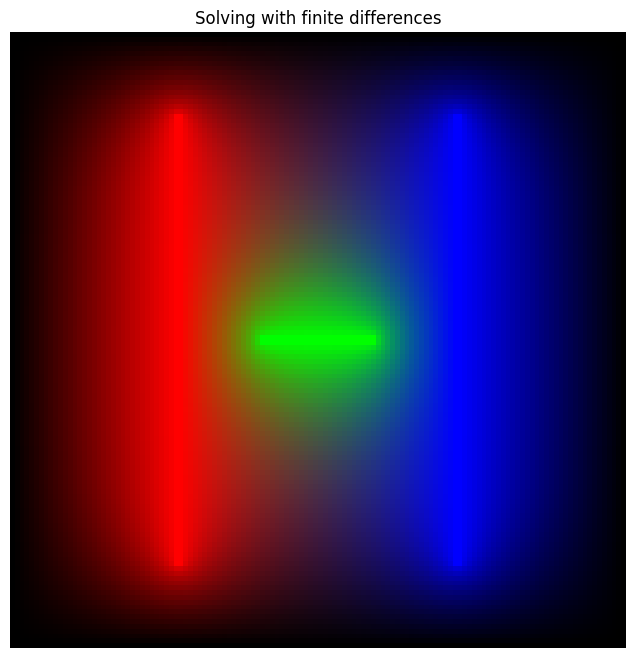

In [38]:
N = 128
x = np.linspace(-1.1, 1.1, N)
y = np.linspace(1.1, -1.1, N) 
X, Y = np.meshgrid(x, y)

points_grid = np.column_stack([X.ravel(), Y.ravel()])
V_flat = np.zeros((N*N, 3))       # Colors
Fixed_flat = np.zeros(N*N, dtype=bool) # wall

thickness = 0.015

for line in lines:

    d = sd_segment_vectorized(points_grid, line['a'], line['b'])
    mask = d < thickness
    V_flat[mask] = line['color']
    Fixed_flat[mask] = True

V = V_flat.reshape((N, N, 3))
Fixed = Fixed_flat.reshape((N, N))

V[0, :, :] = 0; Fixed[0, :] = True
V[-1, :, :] = 0; Fixed[-1, :] = True
V[:, 0, :] = 0; Fixed[:, 0] = True
V[:, -1, :] = 0; Fixed[:, -1] = True


# Solve with FDM
max_iter = 5000

for k in range(max_iter):

    V_neighbors = 0.25 * (V[0:-2, 1:-1] + V[2:, 1:-1] + V[1:-1, 0:-2] + V[1:-1, 2:])
    mask_center = ~Fixed[1:-1, 1:-1]
    current_center = V[1:-1, 1:-1]
    current_center[mask_center] = V_neighbors[mask_center]
    V[1:-1, 1:-1] = current_center
    

plt.figure(figsize=(8, 8))
plt.imshow(V, extent=[-1.1, 1.1, -1.1, 1.1])
plt.title("Solving with finite differences")
plt.axis('off')

### Theroritical Verification 

- Error convergence 

   Samples:    4 | RMSE: 0.15960
   Samples:   16 | RMSE: 0.07881
   Samples:   64 | RMSE: 0.03993
   Samples:  256 | RMSE: 0.02023
   Samples: 1024 | RMSE: 0.01079


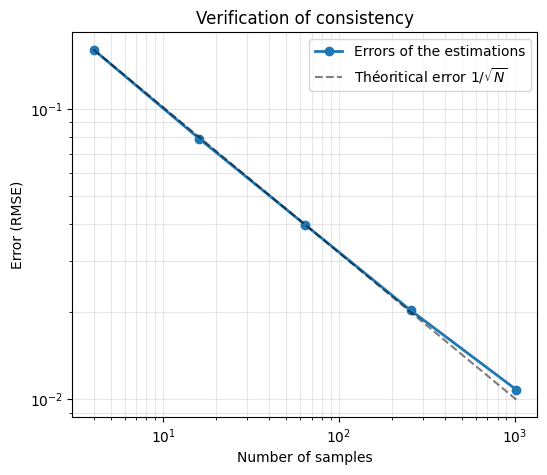

In [162]:
RES = 64  
EPSILON = 1e-4 
REF_SAMPLES = 8192 


img_ref = image = solve_wos_generic(
    res=RES, 
    n_samples=REF_SAMPLES, 
    sdf_func=my_sdf,       
    bc_func=my_shader,     
    bg_val=np.array([0., 0., 0.])
)


sample_counts = [4, 16, 64, 256, 1024]
errors = []

for ns in sample_counts:
    img_wos = solve_wos_generic(
        res=RES, 
        n_samples=ns, 
        sdf_func=my_sdf,       
        bc_func=my_shader,     
        bg_val=np.array([0., 0., 0.]) )
    
    diff = img_wos - img_ref
    rmse = np.sqrt(np.mean(diff**2))
    errors.append(rmse)
    print(f"   Samples: {ns:4d} | RMSE: {rmse:.5f}")


plt.figure(figsize=(6, 5))
plt.loglog(sample_counts, errors, 'o-', linewidth=2, label='Errors of the estimations')

theo_y = [errors[0] * np.sqrt(sample_counts[0]) / np.sqrt(x) for x in sample_counts]
plt.loglog(sample_counts, theo_y, 'k--', alpha=0.5, label=r'Théoritical error $1/\sqrt{N}$')

plt.grid(True, which="both", alpha=0.3)
plt.xlabel("Number of samples")
plt.ylabel("Error (RMSE)")
plt.title("Verification of consistency")
plt.legend()
plt.show()

We can see that the error of our estimators is in $O(1/\sqrt{N})$.

Finish in 4.12s


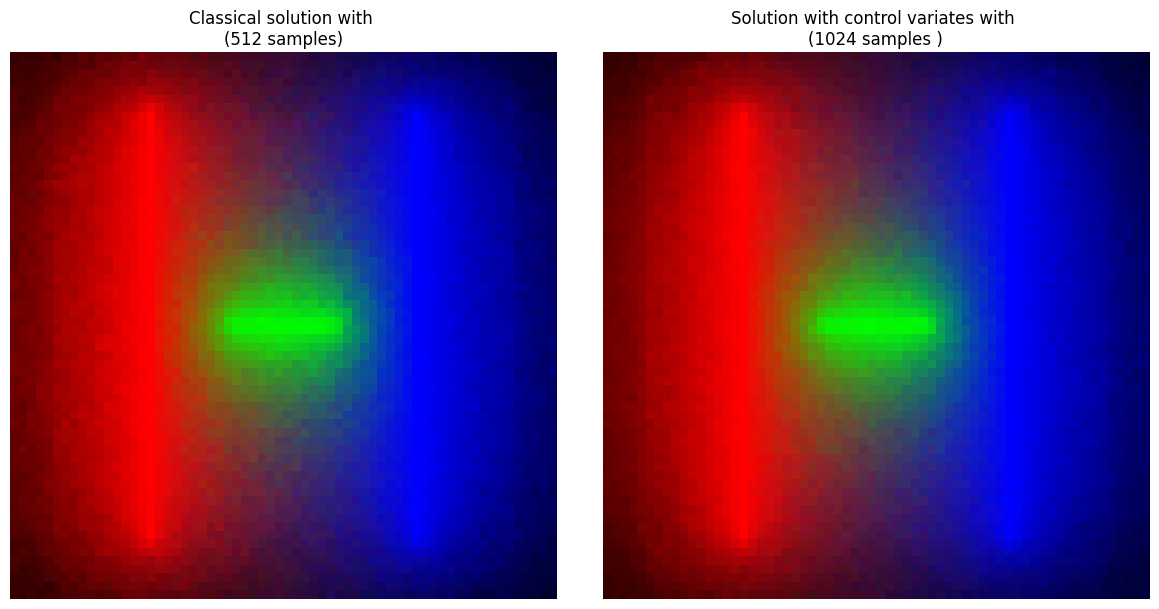

In [176]:
RES = 64
SAMPLES = 1024

t0 = time.time()

img_pilot, img_final = render_cv_generic(
    res=RES, 
    total_samples=SAMPLES, 
    sdf_func=my_sdf,      
    bc_func=my_shader,    
    bg_val=np.array([0., 0., 0.]) 
)

print(f"Finish in {time.time()-t0:.2f}s")


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(np.clip(img_pilot, 0, 1), extent=[-1,1,-1,1])
plt.title(f"Classical solution with \n({SAMPLES//2} samples)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.clip(img_final, 0, 1), extent=[-1,1,-1,1])
plt.title(f"Solution with control variates with \n({SAMPLES} samples )")
plt.axis('off')

plt.tight_layout()
plt.show()

Mean var of standard estimator : 0.098612
Mean var of estimator with control variates : 0.078502
Gain between estimators: 1.26x


/var/folders/vm/951zcnvn12z0rcgdyj5svs0c0000gn/T/ipykernel_57956/3178955513.py:93: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(ratio_map), extent=[-1,1,-1,1], cmap='viridis')


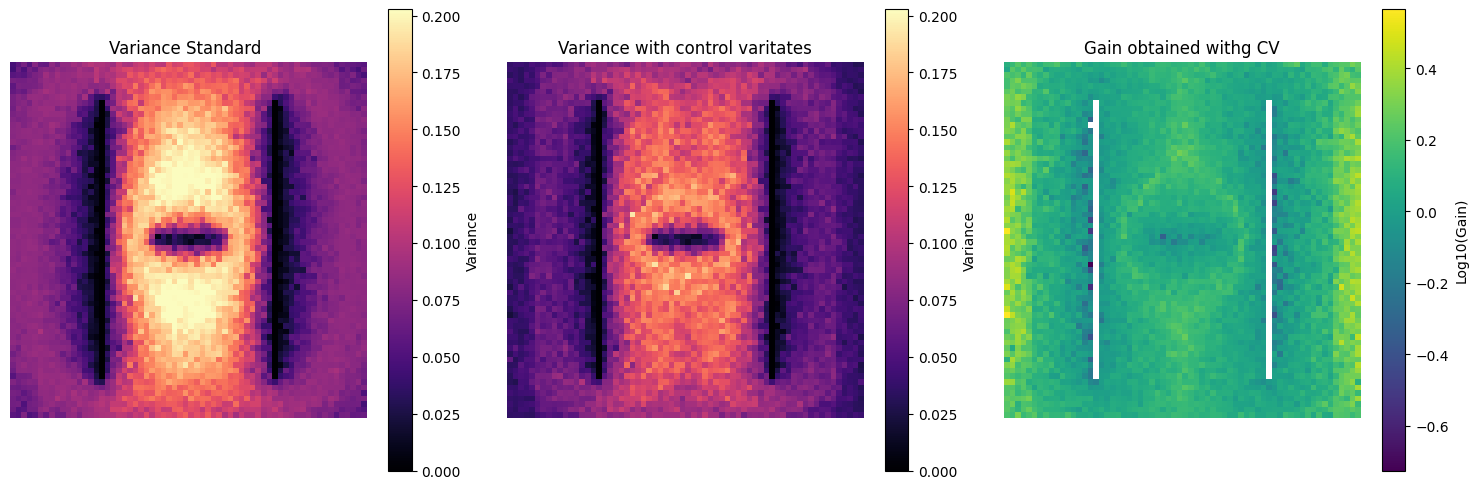

In [178]:
def analyze_cv_performance(res, total_samples, sdf_func, bc_func, bg_val):
    """
    Compute the noise generated by the estimator
    """
    
    n_pilot = max(4, total_samples // 2)
    n_final = total_samples - n_pilot
    
    is_scalar = np.isscalar(bg_val)
    dim = 1 if is_scalar else len(bg_val)
    
    vals_p, R_p, off_p = solve_wos_generic(res, n_pilot, sdf_func, bc_func, bg_val, return_raw=True)
    
    vals_exp = vals_p.reshape(-1, dim, 1) if not is_scalar else vals_p.reshape(-1, 1, 1)
    off_exp = off_p[:, np.newaxis, :]
    R_sq = (R_p**2 + 1e-8).reshape(-1, 1, 1)
    
    grads_particles = (2.0 * vals_exp * off_exp) / R_sq
    grads_reshaped = grads_particles.reshape(res*res, n_pilot, dim, 2)
    mean_gradient_field = np.mean(grads_reshaped, axis=1) # (N_pixels, Dim, 2)
    
    # Comparison between model (control variate vs Standard solution)
    vals_f, _, off_f = solve_wos_generic(res, n_final, sdf_func, bc_func, bg_val, return_raw=True)
    
    if is_scalar:
        stack_std = vals_f.reshape(res*res, n_final)
    else:
        stack_std = vals_f.reshape(res*res, n_final, dim)
        
    grad_per_particle = np.repeat(mean_gradient_field, n_final, axis=0)
    off_f_exp = off_f[:, np.newaxis, :]
    correction = np.sum(grad_per_particle * off_f_exp, axis=2)
    
    vals_corrected = vals_f.reshape(-1, dim) - correction
    
    if is_scalar:
        stack_cv = vals_corrected.reshape(res*res, n_final)
    else:
        stack_cv = vals_corrected.reshape(res*res, n_final, dim)

    # variance calculus 
    
    if is_scalar:
        var_std = np.var(stack_std, axis=1).reshape(res, res)
        var_cv = np.var(stack_cv, axis=1).reshape(res, res)
    else:
        var_std = np.mean(np.var(stack_std, axis=1), axis=1).reshape(res, res)
        var_cv = np.mean(np.var(stack_cv, axis=1), axis=1).reshape(res, res)
        
    return var_std, var_cv

# parmeters 
RES = 64
SAMPLES = 256 
t0 = time.time()

var_std, var_cv = analyze_cv_performance(
    res=RES, 
    total_samples=SAMPLES, 
    sdf_func=my_sdf,    
    bc_func=my_shader, 
    bg_val=np.array([0., 0., 0.])
)

mean_var_std = np.mean(var_std)
mean_var_cv = np.mean(var_cv)
gain = mean_var_std / mean_var_cv

print(f"Mean var of standard estimator : {mean_var_std:.6f}")
print(f"Mean var of estimator with control variates : {mean_var_cv:.6f}")
print(f"Gain between estimators: {gain:.2f}x")

# plot
plt.figure(figsize=(15, 5))

vmax = np.percentile(var_std, 98) 

plt.subplot(1, 3, 1)
plt.imshow(var_std, extent=[-1,1,-1,1], cmap='magma', vmin=0, vmax=vmax)
plt.colorbar(label='Variance')
plt.title("Variance Standard ")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(var_cv, extent=[-1,1,-1,1], cmap='magma', vmin=0, vmax=vmax)
plt.colorbar(label='Variance')
plt.title(f"Variance with control varitates")
plt.axis('off')

ratio_map = var_std / (var_cv + 1e-9)

plt.subplot(1, 3, 3)
plt.imshow(np.log10(ratio_map), extent=[-1,1,-1,1], cmap='viridis')
plt.colorbar(label='Log10(Gain)')
plt.title("Gain obtained withg CV")
plt.axis('off')

plt.tight_layout()
plt.show()

The control variate has reduced the variance of our estimators, making a cleaner solution. 

Another type of method to reduce variance is the importance Sampling, that is note implemented here.

## FEM

The aim of this part is to see the limit of old classical method (finite element method) in comparison with the Walk on Sphere algorithm. The main problem of the FEM comes with the discretisation of space that can conduct to a long time of computation and loose in accuracy.

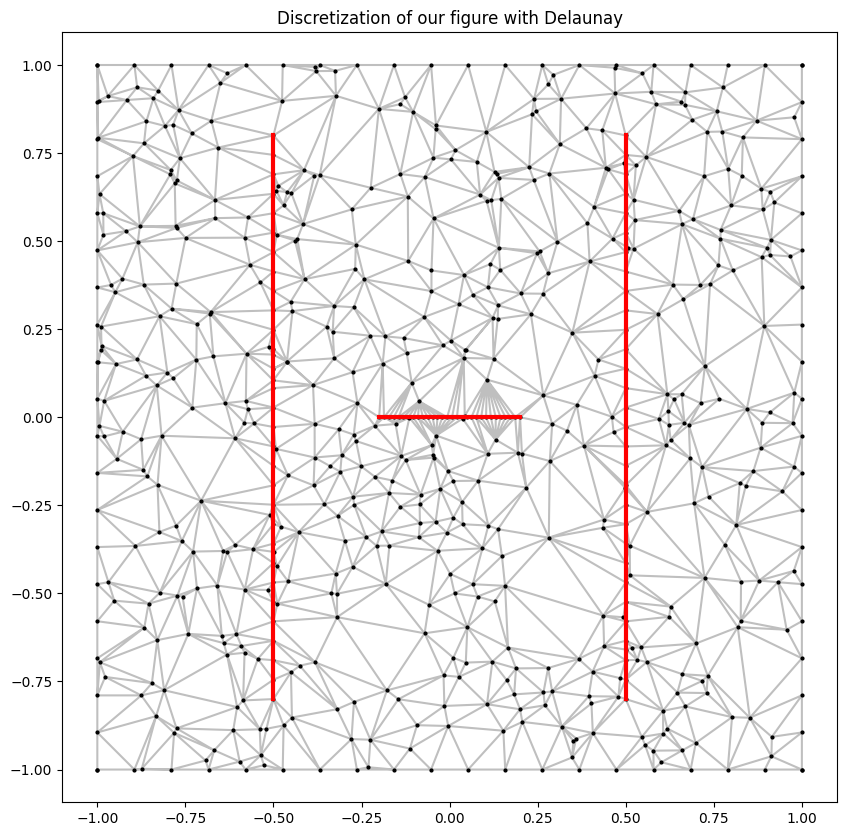

In [179]:
points = []
for line in lines:
    pts = generate_points_on_segment(line['a'], line['b'], density=30)
    points.extend(pts)

box_x = np.linspace(-1, 1, 20)
box_y = np.linspace(-1, 1, 20)

points.extend([np.array([x, 1.0]) for x in box_x])
points.extend([np.array([x, -1.0]) for x in box_x])
points.extend([np.array([-1.0, y]) for y in box_y])
points.extend([np.array([1.0, y]) for y in box_y])

n_fill = 500
fill_pts = np.random.uniform(-1, 1, (n_fill, 2))
points.extend(fill_pts)

points = np.array(points)

# Delaunay methods
tri = Delaunay(points)

plt.figure(figsize=(10, 10))
plt.triplot(points[:,0], points[:,1], tri.simplices, color='gray', alpha=0.5)
plt.plot(points[:,0], points[:,1], 'o', markersize=2, color='black')

for line in lines:
    plt.plot([line['a'][0], line['b'][0]], [line['a'][1], line['b'][1]], 
             linewidth=3, color='red')

plt.title("Discretization of our figure with Delaunay")
plt.axis('equal')
plt.show()

Résolution du système sparse (3300 noeuds)...


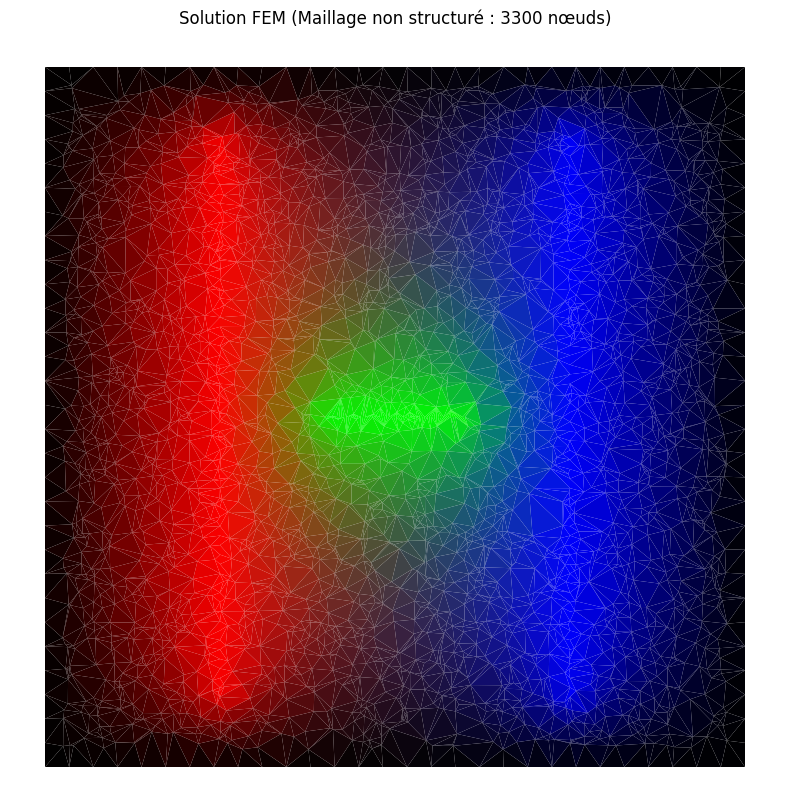

In [181]:
# Delaunay
nodes, elems, bc_idx, bc_vals = generate_mesh_from_lines(lines, density=60, n_fill=3000)
# Solving with FEM
U_fem = solve_fem_rgb(nodes, elems, bc_idx, bc_vals)

plt.figure(figsize=(10, 10))
plot_fem_mesh(nodes, elems, U_fem)
plt.title(f"Solution FEM (Maillage non structuré : {len(nodes)} nœuds)")
plt.show()

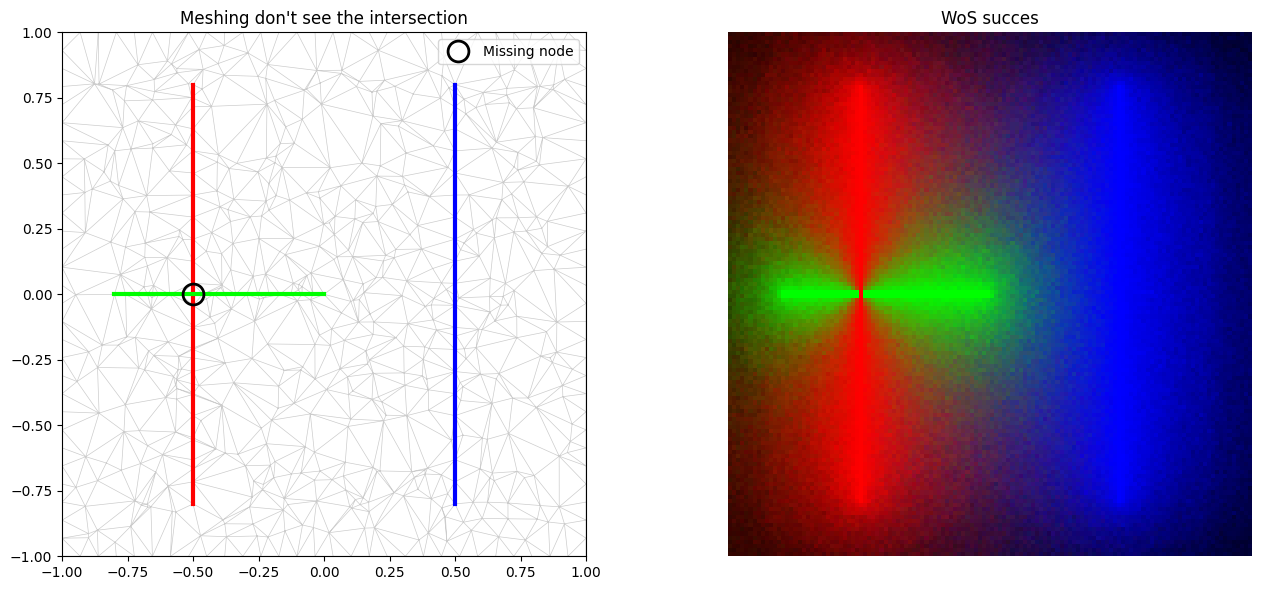

In [182]:
lines_crash = [
    {'a': np.array([-0.5, -0.8]), 'b': np.array([-0.5, 0.8]), 'color': [1.0, 0.0, 0.0]}, 
    {'a': np.array([ 0.5, -0.8]), 'b': np.array([ 0.5, 0.8]), 'color': [0.0, 0.0, 1.0]}, 
    {'a': np.array([-0.8,  0.0]), 'b': np.array([ 0.0,  0.0]), 'color': [0.0, 1.0, 0.0]}, 
]

A_crash = np.array([l['a'] for l in lines_crash])
B_crash = np.array([l['b'] for l in lines_crash])
C_crash = np.array([l['color'] for l in lines_crash])

# Meshing fail 
nodes, elems, _, _ = generate_mesh_from_lines(lines_crash, density=20, n_fill=500)

# WoS algorithm
sdf_crash = lambda p: get_min_dist_vectorized(p, A_crash, B_crash)
shader_crash = lambda p: get_hit_color_vectorized(p, A_crash, B_crash, C_crash)

img_wos = solve_wos_generic(
    res=128, 
    n_samples=256, 
    sdf_func=sdf_crash, 
    bc_func=shader_crash, 
    bg_val=np.array([0.0, 0.0, 0.0]) 
)

plt.figure(figsize=(14, 6))

# Mesh
plt.subplot(1, 2, 1)
plt.title("Meshing don't see the intersection")
plt.triplot(nodes[:,0], nodes[:,1], elems, color='gray', alpha=0.4, linewidth=0.5)

for l in lines_crash:
    plt.plot([l['a'][0], l['b'][0]], [l['a'][1], l['b'][1]], lw=3, c=l['color'])

plt.plot(-0.5, 0, 'ko', markersize=15, markerfacecolor='none', markeredgewidth=2, label="Missing node")
plt.legend(loc='upper right')
plt.xlim(-1, 1); plt.ylim(-1, 1)
plt.gca().set_aspect('equal')

# plot WoS
plt.subplot(1, 2, 2)
plt.title("WoS succes")
plt.imshow(img_wos, extent=[-1, 1, -1, 1], origin='upper')
plt.axis('off')
plt.tight_layout()
plt.show()

Résolution du système sparse (2240 noeuds)...


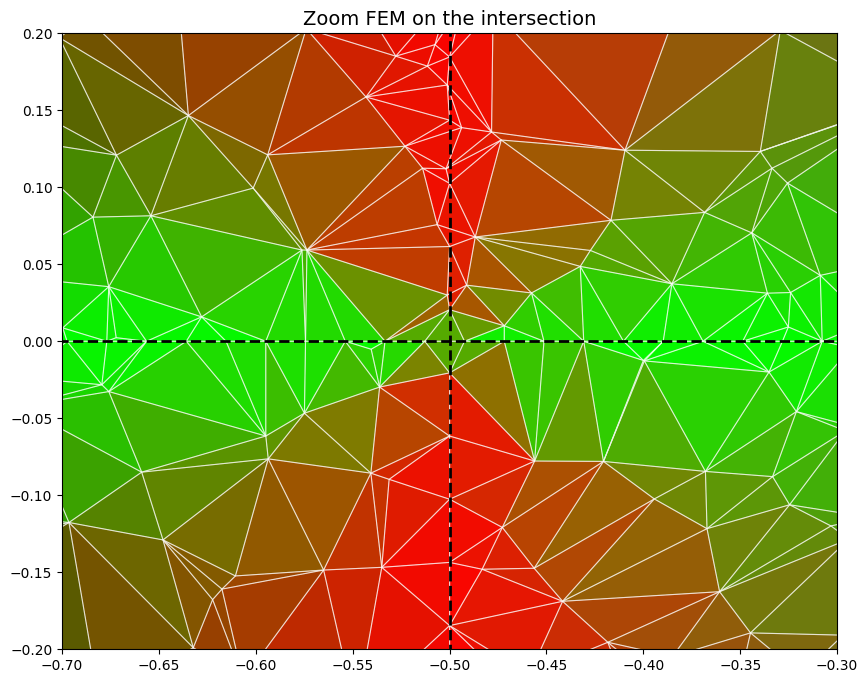

In [183]:
nodes, elems, bc_idx, bc_vals = generate_mesh_from_lines(lines_crash, density=40, n_fill=2000)
U_fem = solve_fem_rgb(nodes, elems, bc_idx, bc_vals)

plt.figure(figsize=(10, 8))
ax = plt.gca()
# FEM
U_tri = U_fem[elems].mean(axis=1)
collection = PolyCollection(nodes[elems], array=None, facecolors=np.clip(U_tri, 0, 1), edgecolors='none')
ax.add_collection(collection)
collection_wire = PolyCollection(nodes[elems], array=None, facecolors='none', edgecolors='white', linewidths=0.8, alpha=0.5)
ax.add_collection(collection_wire)

for line in lines_crash:
    plt.plot([line['a'][0], line['b'][0]], [line['a'][1], line['b'][1]], 
             color='black', linewidth=2, linestyle='--')


# ZOOM 
plt.xlim(-0.7, -0.3)
plt.ylim(-0.2, 0.2)

plt.title("Zoom FEM on the intersection", fontsize=14)
plt.show()

First we can see that the FEM method don't see the intersection between red and green lines that make the process choose a color between red and green. 

Finish in 2.03s


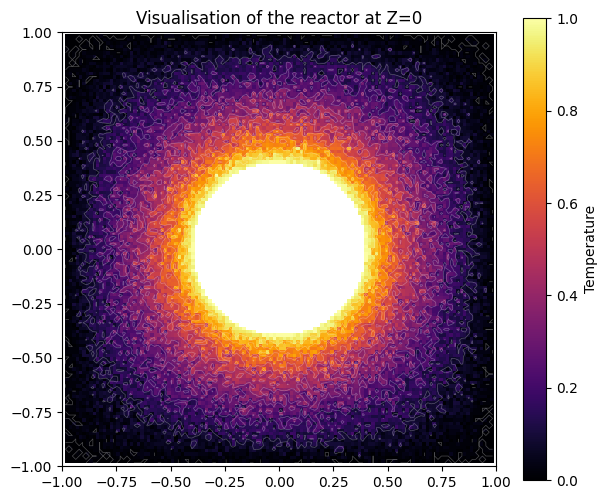

In [187]:
RES = 128
x = np.linspace(-1, 1, RES)
y = np.linspace(1, -1, RES)
X, Y = np.meshgrid(x, y)
starts_3d = np.stack([X.ravel(), Y.ravel(), np.zeros_like(X.ravel())], axis=1)

d_check = sdf_reactor_3d(starts_3d)
valid_mask = d_check > 0 

# WoS
t0 = time.time()
values_valid = solve_wos_generic2(
    res=starts_3d[valid_mask], 
    n_samples=64,
    sdf_func=sdf_reactor_3d,
    bc_func=bc_reactor_3d,
    bg_val=0.0 
)

print(f"Finish in {time.time()-t0:.2f}s")

# Plot

img_final = np.full(RES*RES, np.nan)
img_final[valid_mask] = values_valid
img_final = img_final.reshape(RES, RES)


plt.figure(figsize=(7, 6))
plt.imshow(img_final, extent=[-1,1,-1,1], cmap='inferno')
plt.colorbar(label='Temperature')
plt.title("Visualisation of the reactor at Z=0")
plt.contour(X, Y, img_final, levels=10, colors='white', alpha=0.3, linewidths=0.5)
plt.show()

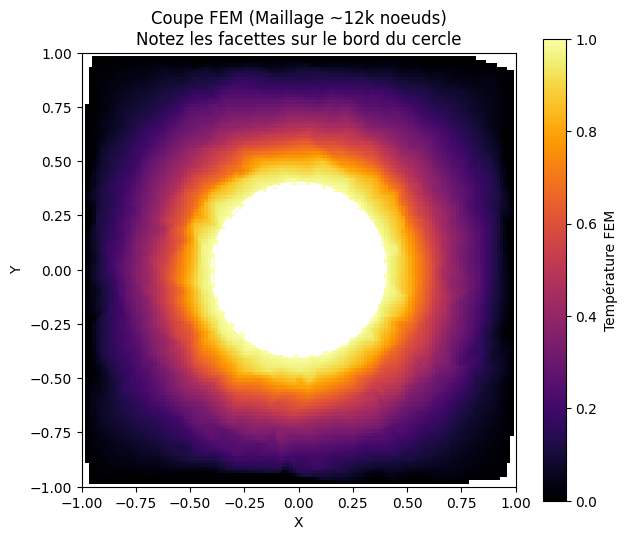

In [189]:
N_POINTS = 10000
BOX_SIZE = 1.0
SPHERE_RADIUS = 0.4

def generate_rough_3d_mesh():

    nodes = np.random.uniform(-BOX_SIZE, BOX_SIZE, (int(N_POINTS * 1.5), 3))
    
    dists = np.linalg.norm(nodes, axis=1)
    mask_keep = dists > SPHERE_RADIUS
    nodes = nodes[mask_keep][:N_POINTS]
    
    n_surf = 2000
    vec = np.random.normal(0, 1, (n_surf, 3))
    vec /= np.linalg.norm(vec, axis=1)[:, None]
    surf_pts = vec * SPHERE_RADIUS
    nodes = np.vstack([nodes, surf_pts])
    
    # Meshing
    
    tri = Delaunay(nodes)
    elems = tri.simplices
    
    centroids = np.mean(nodes[elems], axis=1)
    dist_cent = np.linalg.norm(centroids, axis=1)
    valid_tets = dist_cent > SPHERE_RADIUS
    elems = elems[valid_tets]
    
    # solve
    dists_nodes = np.linalg.norm(nodes, axis=1)
    mask_sphere = dists_nodes <= (SPHERE_RADIUS + 0.02)
    mask_box = np.max(np.abs(nodes), axis=1) > (BOX_SIZE - 0.05)
    
    bcs = []
    for i in range(len(nodes)):
        if mask_sphere[i]: bcs.append((i, 1.0))
        elif mask_box[i]:  bcs.append((i, 0.0))
            
    return nodes, elems, bcs

def solve_fem_approx(nodes, elems, bcs):
    N = len(nodes)
    A = lil_matrix((N, N))
    b = np.zeros(N)
    
    edges = set()
    for tet in elems:
        for i in range(4):
            for j in range(i+1, 4):
                u, v = (tet[i], tet[j]) if tet[i] < tet[j] else (tet[j], tet[i])
                edges.add((u, v))
    
    for u, v in edges:
        dist = np.linalg.norm(nodes[u] - nodes[v])
        weight = 1.0 / (dist + 1e-9)
        A[u, v] = A[v, u] = -weight
        A[u, u] += weight
        A[v, v] += weight
        
    # Border condition
    for idx, val in bcs:
        A[idx, :] = 0
        A[idx, idx] = 1
        b[idx] = val
        
    return spsolve(A.tocsr(), b)

t0 = time.time()
nodes, elems, bcs = generate_rough_3d_mesh()
u_fem = solve_fem_approx(nodes, elems, bcs)
RES = 128
x_grid = np.linspace(-1, 1, RES)
y_grid = np.linspace(1, -1, RES)
X, Y = np.meshgrid(x_grid, y_grid)

mask_slice = np.abs(nodes[:, 2]) < 0.1
points_slice = nodes[mask_slice]
values_slice = u_fem[mask_slice]

img_fem = griddata(points_slice[:, :2], values_slice, (X, Y), method='linear')

dist_grid = np.sqrt(X**2 + Y**2)
img_fem[dist_grid < SPHERE_RADIUS] = np.nan


plt.figure(figsize=(7, 6))
plt.imshow(img_fem, extent=[-1, 1, -1, 1], cmap='inferno')
plt.colorbar(label='Température FEM')

# Real solution 
circle = plt.Circle((0, 0), SPHERE_RADIUS, color='white', fill=False, linestyle='--', linewidth=2)
plt.gca().add_patch(circle)
plt.text(0, 0, "Zone Vide\n(Interpolation)", color='white', ha='center', fontweight='bold')

plt.title(f"Coupe FEM (Maillage ~{len(nodes)//1000}k noeuds)\nNotez les facettes sur le bord du cercle")
plt.xlabel("X"); plt.ylabel("Y")
plt.show()

The FEM model loose in precision with the circle and have problem to mesh our circle. We have to increase the number of nodes to have a more precise solution. However, the computation time explodes with the number of nodes. The WoS is more robust to this geometry and the computation don't explode with time. 

## Bézier curves 

Another field where the WoS is useful corresponds to the Bézier curves where the estimator will approximate a more accurate solution than FEM.

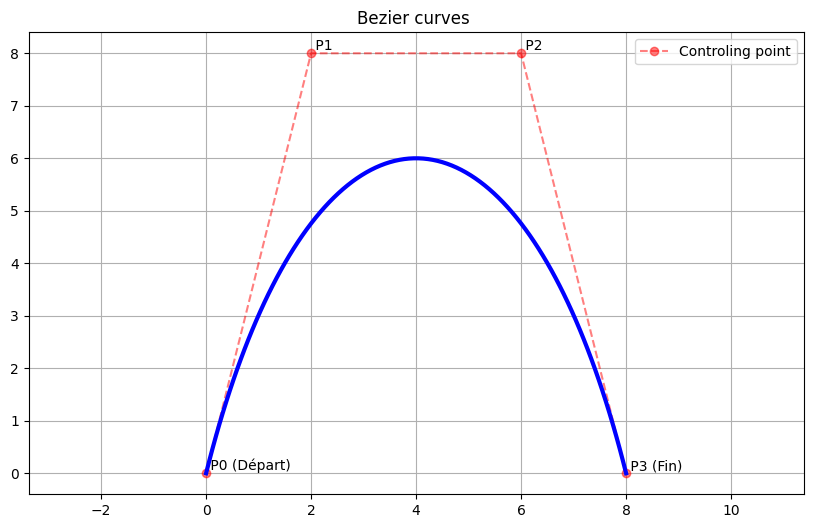

In [191]:
P0 = np.array([0, 0])   # Start
P1 = np.array([2, 8])   # attracting point
P2 = np.array([6, 8])  
P3 = np.array([8, 0])   # Finish 

# creation of a curve 
t_values = np.linspace(0, 1, 100)
curve_points = np.array([cubic_bezier(t, P0, P1, P2, P3) for t in t_values])

plt.figure(figsize=(10, 6))

controls = np.array([P0, P1, P2, P3])
plt.plot(controls[:, 0], controls[:, 1], 'ro--', label="Controling point", alpha=0.5)
plt.text(P0[0], P0[1], ' P0 (Départ)', verticalalignment='bottom')
plt.text(P1[0], P1[1], ' P1', verticalalignment='bottom')
plt.text(P2[0], P2[1], ' P2', verticalalignment='bottom')
plt.text(P3[0], P3[1], ' P3 (Fin)', verticalalignment='bottom')

plt.plot(curve_points[:, 0], curve_points[:, 1], 'b-', linewidth=3)

# Décoration du graphique
plt.title("Bezier curves ")
plt.legend()
plt.grid(True)
plt.axis('equal')

plt.show()

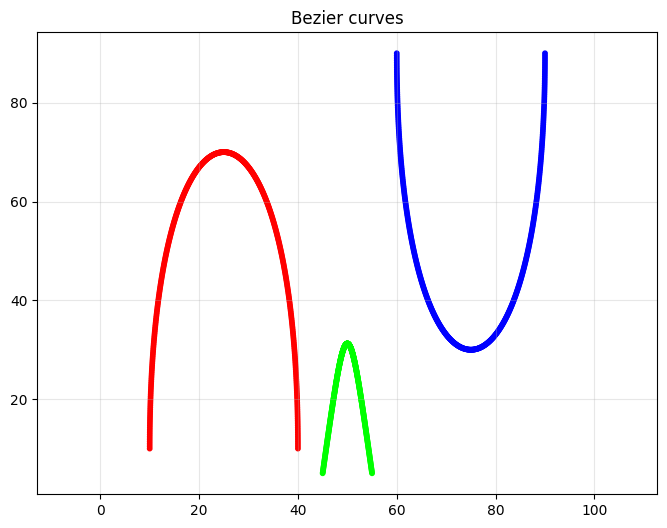

In [192]:
scene = FastCurveScene()
scene.add_curve([10, 10], [10, 90], [40, 90], [40, 10], [1, 0, 0]) # Rouge
scene.add_curve([90, 90], [90, 10], [60, 10], [60, 90], [0, 0, 1]) # Bleu
scene.add_curve([45, 5], [50, 40], [50, 40], [55, 5], [0, 1, 0])   # Vert
scene.build()


plt.figure(figsize=(8, 6))

pts = scene.all_points
cols = scene.all_colors

plt.scatter(pts[:, 0], pts[:, 1], c=cols, s=10)
plt.title(f"Bezier curves")
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

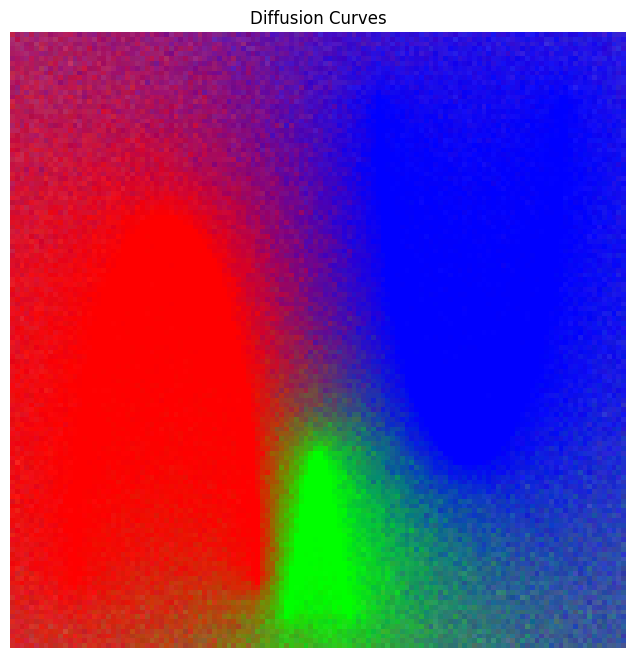

In [193]:
def render_frame(width, height, scene, n_samples=100, batch_size=10):
    """
    Solve the WoS 
    """

    x = np.linspace(0, 100, width)
    y = np.linspace(0, 100, height)
    xv, yv = np.meshgrid(x, y)
    grid_points = np.column_stack([xv.ravel(), yv.ravel()])
    accumulation_buffer = np.zeros((len(grid_points), 3), dtype=np.float32)
    
    for i in range(n_samples):
        pass_colors = solve_wos_pass(grid_points, scene, epsilon=0.5)
        accumulation_buffer += pass_colors
        
    final_colors = accumulation_buffer / n_samples
    return final_colors.reshape(height, width, 3)

RES = 128
SAMPLES = 100

image = render_frame(RES, RES, scene, n_samples=SAMPLES)

plt.figure(figsize=(8, 8))
plt.imshow(image, origin='lower', extent=[0, 100, 0, 100])
plt.title(f"Diffusion Curves")
plt.axis('off')
plt.show()

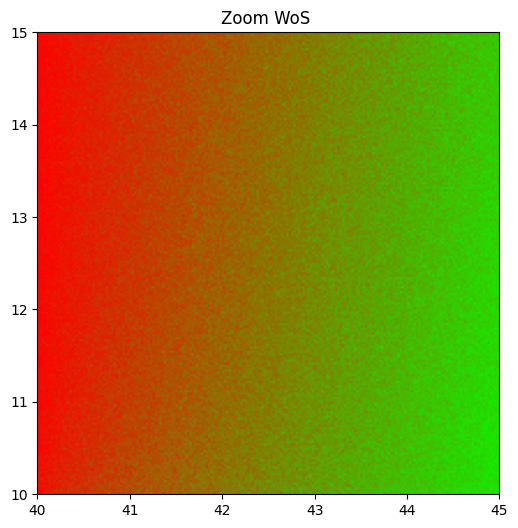

In [194]:
def render_frame_zoom(width, height, scene, viewport, n_samples=100, epsilon=0.5):
    """
    viewport = (x_min, x_max, y_min, y_max)
    """
    x_min, x_max, y_min, y_max = viewport
    
    x = np.linspace(x_min, x_max, width)
    y = np.linspace(y_min, y_max, height)
    xv, yv = np.meshgrid(x, y)
    grid_points = np.column_stack([xv.ravel(), yv.ravel()])
    
    acc_buffer = np.zeros((len(grid_points), 3), dtype=np.float32)
    
    for i in range(n_samples):
        pass_colors = solve_wos_pass(grid_points, scene, epsilon=epsilon)
        acc_buffer += pass_colors
            
    final_colors = acc_buffer / n_samples
    return final_colors.reshape(height, width, 3)


ZOOM_AREA = (40, 45, 10, 15) 
RES = 200
SAMPLES = 100
final_zoom = render_frame_zoom(RES, RES, scene, viewport=ZOOM_AREA, n_samples=SAMPLES, epsilon=0.05)

plt.figure(figsize=(6, 6))
plt.imshow(final_zoom, origin='lower', extent=ZOOM_AREA)
plt.title(f"Zoom WoS ")
plt.axis('on')
plt.show()

A major advantage of WoS algorithm is that it allows to zoom at infinity without loosing in accuracy contrary to FEM.

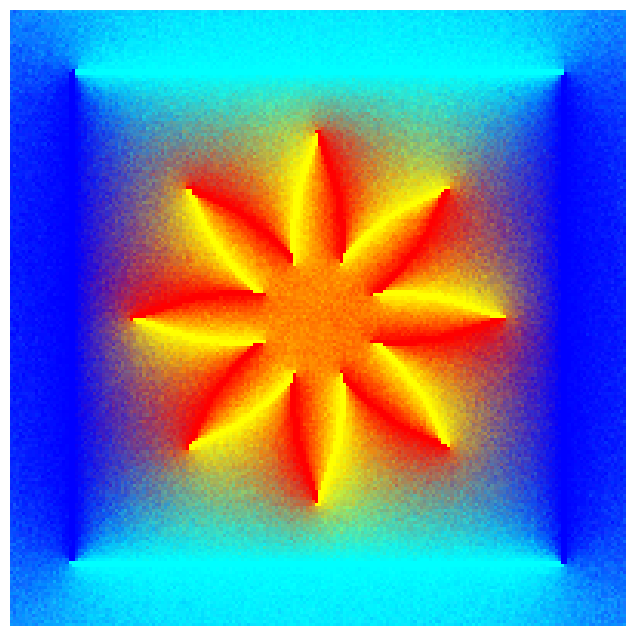

In [195]:
def create_complex_star(scene, center, radius_outer, radius_inner, num_spikes, c1, c2):
    cx, cy = center
    step = 2 * np.pi / (num_spikes * 2)
    for i in range(num_spikes * 2):
        a1, a2 = i*step, (i+1)*step
        r1 = radius_outer if i%2==0 else radius_inner
        r2 = radius_inner if i%2==0 else radius_outer
        p0 = [cx + r1*np.cos(a1), cy + r1*np.sin(a1)]
        p3 = [cx + r2*np.cos(a2), cy + r2*np.sin(a2)]
        cr = (r1+r2)/2
        p1 = [cx + cr*np.cos(a1+0.2), cy + cr*np.sin(a1+0.2)]
        p2 = [cx + cr*np.cos(a2-0.2), cy + cr*np.sin(a2-0.2)]
        scene.add_curve(p0, p1, p2, p3, c2 if i%2==0 else c1)

scene = FastCurveScene()

scene.add_curve([10,10],[10,90],[10,90],[10,90],[0,0,1])
scene.add_curve([10,90],[90,90],[90,90],[90,90],[0,1,1])
scene.add_curve([90,90],[90,10],[90,10],[90,10],[0,0,1])
scene.add_curve([90,10],[10,10],[10,10],[10,10],[0,1,1])

create_complex_star(scene, [50,50], 30, 10, 8, [1,0,0], [1,1,0])
scene.build()

img = render_frame(200, 200, scene, n_samples=100)

plt.figure(figsize=(8, 8))
plt.imshow(img, origin='lower', extent=[0,100,0,100])
plt.axis('off')
plt.show()

## Epsilon effect

<>:28: SyntaxWarning: "\e" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\e"? A raw string is also an option.
<>:28: SyntaxWarning: "\e" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\e"? A raw string is also an option.
/var/folders/vm/951zcnvn12z0rcgdyj5svs0c0000gn/T/ipykernel_57956/1576187488.py:28: SyntaxWarning: "\e" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\e"? A raw string is also an option.
  plt.title(f"$\epsilon = {eps}$\n")


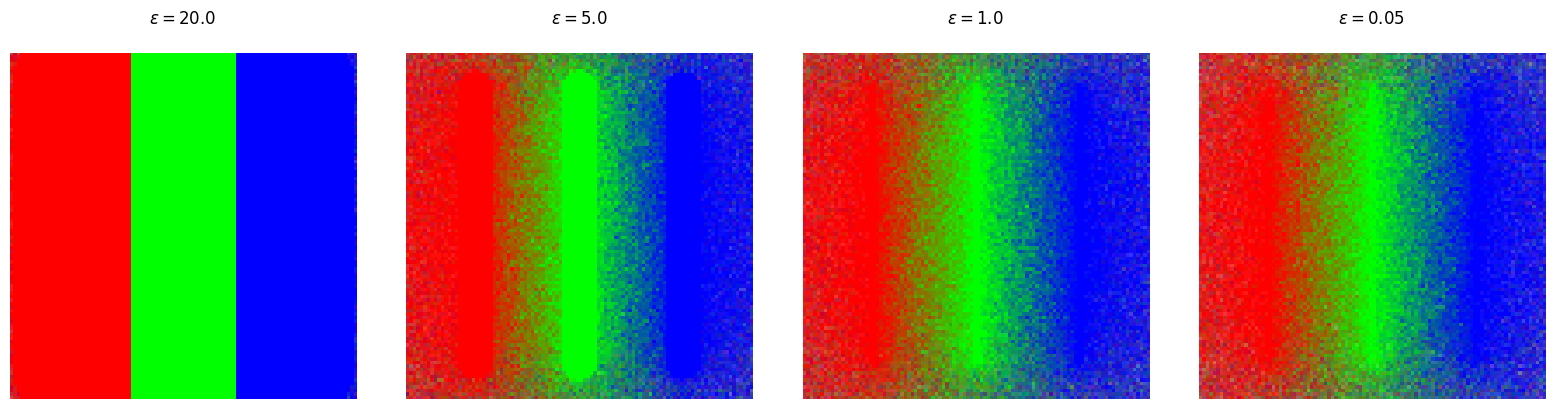

In [196]:
scene = FastCurveScene()

scene.add_curve([20, 10], [20, 10], [20, 90], [20, 90], [1, 0, 0]) 
scene.add_curve([50, 10], [50, 10], [50, 90], [50, 90], [0, 1, 0])
scene.add_curve([80, 10], [80, 10], [80, 90], [80, 90], [0, 0, 1]) 
scene.build()

epsilons = [20.0, 5.0, 1.0, 0.05]
RES = 100
SAMPLES = 20 
x = np.linspace(0, 100, RES)
y = np.linspace(0, 100, RES)
xv, yv = np.meshgrid(x, y)
grid_points = np.column_stack([xv.ravel(), yv.ravel()])

plt.figure(figsize=(16, 4))

for i, eps in enumerate(epsilons):
    
    acc_buffer = np.zeros((len(grid_points), 3), dtype=np.float32)
    for _ in range(SAMPLES):
        acc_buffer += solve_wos_pass(grid_points, scene, epsilon=eps)
    
    final_img = (acc_buffer / SAMPLES).reshape(RES, RES, 3)
    
    plt.subplot(1, 4, i+1)
    plt.imshow(final_img, origin='lower', extent=[0,100,0,100])
    plt.title(f"$\epsilon = {eps}$\n")
    plt.axis('off')

plt.tight_layout()
plt.show()

  Epsilon 20.00 : 0.102 seconds
  Epsilon 10.00 : 0.234 seconds
  Epsilon  5.00 : 0.391 seconds
  Epsilon  1.00 : 0.665 seconds
  Epsilon  0.05 : 1.195 seconds


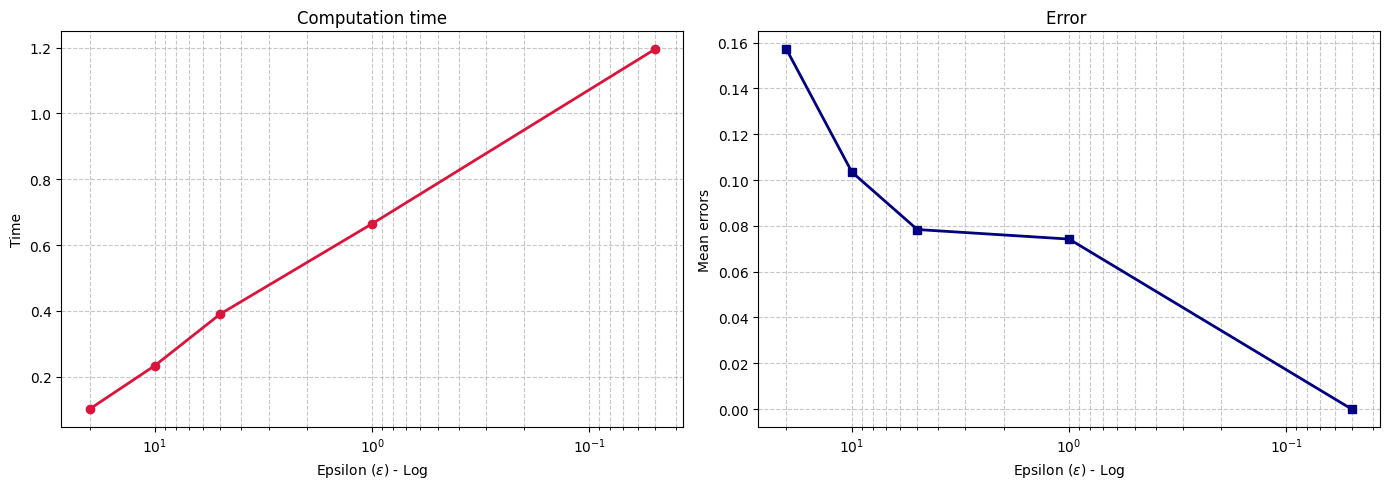

In [197]:
epsilons = [20.0, 10.0, 5.0, 1.0, 0.05]
RES = 100
SAMPLES = 20 

x = np.linspace(0, 100, RES)
y = np.linspace(0, 100, RES)
xv, yv = np.meshgrid(x, y)
grid_points = np.column_stack([xv.ravel(), yv.ravel()])

times = []
images = []


for i, eps in enumerate(epsilons):
    
    start_time = time.time() 
    
    acc_buffer = np.zeros((len(grid_points), 3), dtype=np.float32)
    for _ in range(SAMPLES):
        acc_buffer += solve_wos_pass(grid_points, scene, epsilon=eps)
    

    elapsed = time.time() - start_time
    times.append(elapsed)
    
    final_img = (acc_buffer / SAMPLES).reshape(RES, RES, 3)
    images.append(final_img)
    
    print(f"  Epsilon {eps:5.2f} : {elapsed:.3f} seconds")

# errors 
ref_img = images[-1] 
errors = []

for img in images:
    diff = np.abs(img - ref_img).mean()
    errors.append(diff)

# plot
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epsilons, times, 'o-', color='crimson', linewidth=2)
plt.xscale('log')
plt.gca().invert_xaxis() # Pour avoir les grands epsilons à gauche
plt.title("Computation time")
plt.xlabel(r"Epsilon ($\epsilon$) - Log")
plt.ylabel("Time")
plt.grid(True, which="both", ls="--", alpha=0.7)

# Graphe 2 : Erreur vs Epsilon
plt.subplot(1, 2, 2)
plt.plot(epsilons, errors, 's-', color='navy', linewidth=2)
plt.xscale('log')
plt.gca().invert_xaxis()
plt.title("Error ")
plt.xlabel(r"Epsilon ($\epsilon$) - Log")
plt.ylabel("Mean errors")
plt.grid(True, which="both", ls="--", alpha=0.7)

plt.tight_layout()
plt.show()

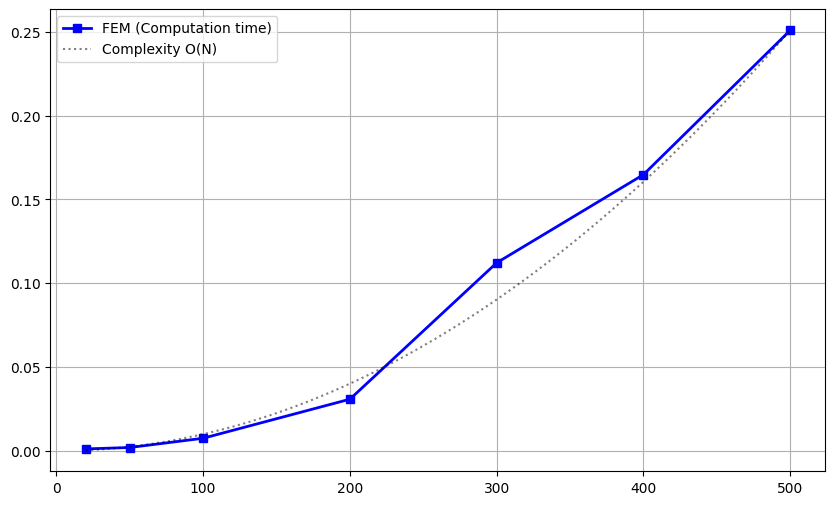

In [198]:
def bench_fem_scaling(resolutions):
    times = []
    memory_complexity = [] 
    
    for res in resolutions:
        N = res * res 
        start_t = time.time()
        A = lil_matrix((N, N))
        b = np.random.rand(N)
        A.setdiag(4) 
        A_csc = A.tocsc()
        _ = spsolve(A_csc, b)
        
        duration = time.time() - start_t
        times.append(duration)
        memory_complexity.append(N)
        
        
    return times, memory_complexity

resolutions = [20, 50, 100, 200, 300, 400, 500] 

times, complexity = bench_fem_scaling(resolutions)

plt.figure(figsize=(10, 6))

plt.plot(resolutions, times, 's-', color='blue', linewidth=2, label="FEM (Computation time)")

x_ref = np.linspace(min(resolutions), max(resolutions), 100)
y_ref = (x_ref / max(resolutions))**2 * max(times) 
plt.plot(x_ref, y_ref, 'k:', label="Complexity O(N)", alpha=0.5)

plt.legend()
plt.grid(True)
plt.show()

A large $\epsilon$ allows us to different applications like voronoï diagram.

<>:25: SyntaxWarning: "\e" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\e"? A raw string is also an option.
<>:25: SyntaxWarning: "\e" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\e"? A raw string is also an option.
/var/folders/vm/951zcnvn12z0rcgdyj5svs0c0000gn/T/ipykernel_57956/2824627870.py:25: SyntaxWarning: "\e" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\e"? A raw string is also an option.
  plt.title(f"voronoï's diagram with WoS($\epsilon \\to \infty$)\n")


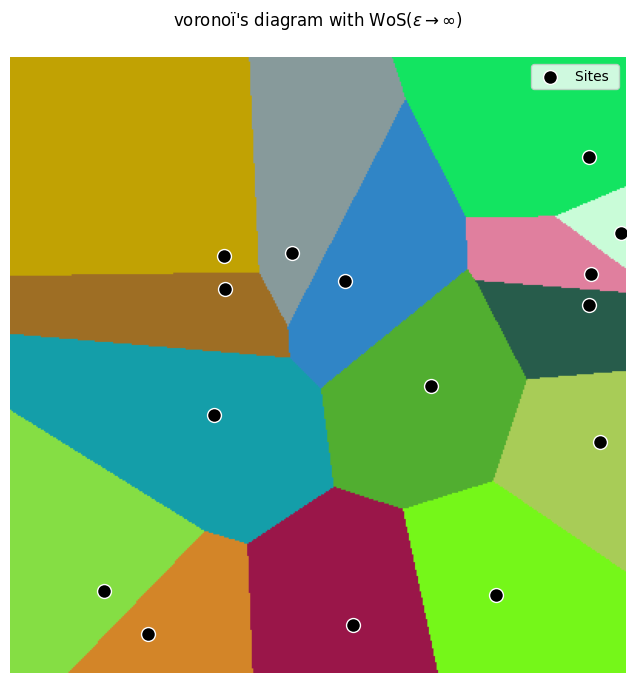

In [199]:
from geometry import *

def solve_voronoi_via_wos(width, height, scene):
    x = np.linspace(0, 100, width)
    y = np.linspace(0, 100, height)
    xv, yv = np.meshgrid(x, y)
    walkers_pos = np.column_stack([xv.ravel(), yv.ravel()])
    
    dists, indices = scene.tree.query(walkers_pos, k=1)
    
    image_colors = scene.colors[indices]
    
    return image_colors.reshape(height, width, 3)


SCENE_SEEDS = 15   
RES = 400          

scene = VoronoiScene(num_seeds=SCENE_SEEDS)
voronoi_img = solve_voronoi_via_wos(RES, RES, scene)

plt.figure(figsize=(10, 8))
plt.imshow(voronoi_img, origin='lower', extent=[0, 100, 0, 100])
plt.scatter(scene.seeds[:, 0], scene.seeds[:, 1], c='black', edgecolors='white', s=100, label='Sites ')
plt.title(f"voronoï's diagram with WoS($\epsilon \\to \infty$)\n")
plt.axis('off')
plt.legend()
plt.show()

## Limitations 

- Blindness : A first thing we can see is that the Walk on Sphere is completely stochastic and don't converge in narrow geometry 

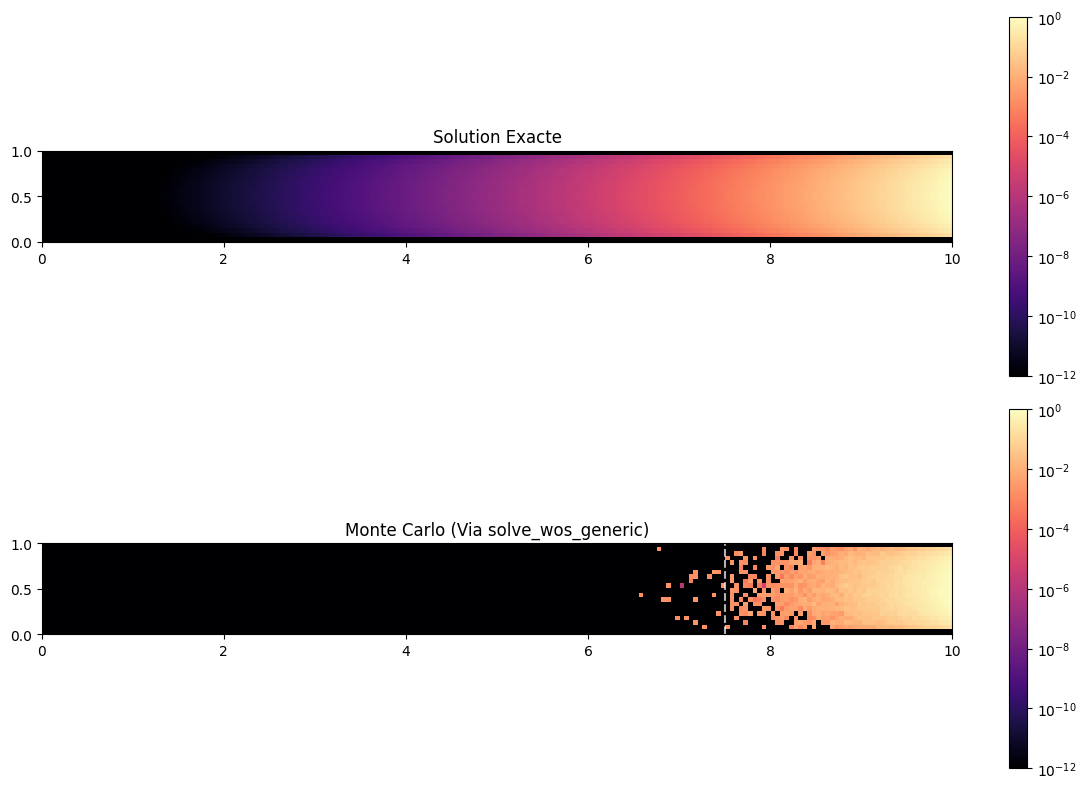

In [201]:
L = 10.0
W = 1.0
RES_X = 200
RES_Y = 20

x_lin = np.linspace(0, L, RES_X)
y_lin = np.linspace(0, W, RES_Y)
X, Y = np.meshgrid(x_lin, y_lin)
grid_points = np.column_stack([X.ravel(), Y.ravel()])

wos_result_flat = solve_wos_generic2(
    res=grid_points,        
    n_samples=500,          
    sdf_func=heat_sdf_wrapper,
    bc_func=heat_bc_wrapper,
    domain_limit=L + 2.0,   
    epsilon=0.01,
    max_steps=100           
)

wos_img = wos_result_flat.reshape(RES_Y, RES_X)

def get_exact_field(X, Y, L, W):
    term_x = np.sinh(np.pi * X / W)
    term_L = np.sinh(np.pi * L / W)
    term_y = np.sin(np.pi * Y / W)
    with np.errstate(over='ignore', invalid='ignore'):
        val = (term_x / term_L) * term_y
    return np.nan_to_num(val)

exact_img = get_exact_field(X, Y, L, W)

wos_img[wos_img <= 0] = 1e-20
exact_img[exact_img <= 0] = 1e-20

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
norm = LogNorm(vmin=1e-12, vmax=1)

# Plot Exact
im1 = axes[0].imshow(exact_img, origin='lower', extent=[0, L, 0, W], cmap='magma', norm=norm)
axes[0].set_title("Solution Exacte")
plt.colorbar(im1, ax=axes[0])

# Plot WoS 
im2 = axes[1].imshow(wos_img, origin='lower', extent=[0, L, 0, W], cmap='magma', norm=norm)
axes[1].set_title("Monte Carlo (Via solve_wos_generic)")
plt.colorbar(im2, ax=axes[1])

axes[1].axvline(x=7.5, color='white', linestyle='--', linewidth=1.5, alpha=0.7)

plt.tight_layout()
plt.show()

We can solve this problem by adding reflecting wall but it will take a lot of times before the walkers go out from the scene due to his stochastic effect.

A second limitation of the Walk On Sphere algorithm comes with the estimation of different order. In fact, when we are close from a wall due to a term in $1/R$ in the gradient estimator, the value can explode and have extreme values. 

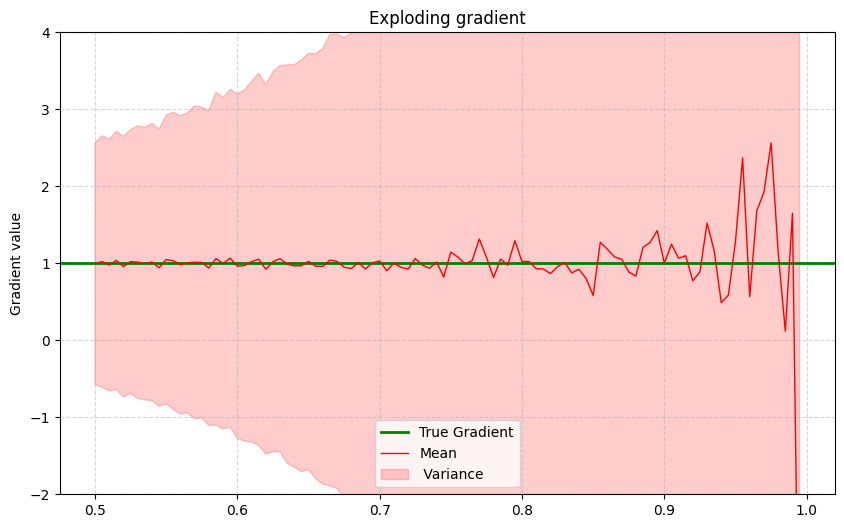

In [202]:
x_positions = np.linspace(0.5, 0.995, 100)
means = []
stds = []

for x in x_positions:
    mu, sigma = estimate_gradient_monte_carlo([x, 0.5], n_samples=2000)
    means.append(mu)
    stds.append(sigma)

means = np.array(means)
stds = np.array(stds)


plt.figure(figsize=(10, 6))

# Truth
plt.axhline(1.0, color='green', linewidth=2, label="True Gradient")

# Monte Carlo
plt.plot(x_positions, means, 'r-', linewidth=1, label="Mean")
# Variance
plt.fill_between(x_positions, means - stds, means + stds, color='red', alpha=0.2, label=" Variance")

plt.title("Exploding gradient")
plt.ylabel("Gradient value")
plt.legend()
plt.ylim(-2, 4) 
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()